In [1]:
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# Algorithms
from minisom import MiniSom
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, r2_score
import sqlite3
from datetime import datetime
import matplotlib.dates as mdates
import warnings

# Suppression warnings pour calcul np sur des NaN
warnings.filterwarnings(action='ignore', message='All-NaN slice encountered')

# Liste des fonctions utilisées

# Fonction de requetage auprès de la base de données sqlite
def f_requete_sql (requete) :
    try:
        connexion = sqlite3.connect('../data/liste_piezos.db')
        curseur = connexion.cursor()
        print("Connexion réussie à SQLite")
        curseur.execute(requete)
        connexion.commit()
        resultat = curseur.fetchall()
        curseur.close()
        connexion.close()
        print("Connexion SQLite est fermée")
        return resultat
    except sqlite3.Error as error:
        print("Erreur lors du mis à jour dans la table", error)
    return resultat

# Fonction d'affichage des valeurs manquantes
def f_plot_nan (dataframe):
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,6))
    sns.heatmap(dataframe.T.isna(), cmap='Blues', cbar=False)
    ax.set_title('Missing Values', fontsize=16)
    # Masquage des noms de piezo 
    ax.yaxis.set_visible(False)
    # Formatage de la date pour l'affichage
    ax.xaxis.set_ticklabels([pd.to_datetime(value).strftime('%Y') for value in ax.xaxis.get_major_formatter().func.args[0].values()])
    plt.show()
        

# Fonction pour standardiser les données
def scaleColumns(df):
    for col in df.columns:
        df[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df[col])),columns=[col], index=df.index)
    return df

# Import des données
## Import des chroniques des clusters

In [2]:
requete = """
select code_bss from flagship_piezo"""

codes = f_requete_sql(requete)

Connexion réussie à SQLite
Connexion SQLite est fermée


In [3]:
code_bss = []
for code in codes:
    code_bss.append(code[0])
code_bss

['06211X0041_P3CAPT',
 '07223C0113_S',
 '07208X0197_F1C',
 '06003X0088_P',
 '05794X0021_PZ1',
 '04992X0011_SONDAG',
 '04994X0204_S',
 '05002X0114_SONDAG',
 '03462X0043_F',
 '03182X0027_PZ',
 '03107X0008_F',
 '04915X0009_F1AEP1',
 '02551X0022_FAEP',
 '05696X0002_FAEP',
 '01815X0006_FAEP',
 '03787X0109_60A',
 '03795X0037_55',
 '03078X0014_214',
 '00115X0011_P1',
 '00632X0023_P',
 '00263X0006_P1',
 '00801X0005_S1',
 '02584X0024_FCH7',
 '02218X0033_P6',
 '02182X0004_P2',
 '02203X0002_S1',
 '01551X1013_S1',
 '07545X0002_F1',
 '09258X0005_F',
 '08754X0028_P',
 '08031X0302_P1',
 '08046X0005_F2',
 '09508X0063_F',
 '01168X0065_P',
 '01011X0045_P',
 '00583X0005_S1',
 '09916X0098_LANSAR',
 '10912X0111_BAR4',
 '09914X0370_PERRIE',
 '10897X0010_F3',
 '09406X0643_P130',
 '09668X0106_16',
 '05082X0181_PZ',
 '05865X0126_S',
 '04851X0091_PZ']

In [4]:
directory = '../data/piezo/'
data = pd.read_csv(directory+f"{code_bss[0]}.csv", sep=";",  index_col=0, parse_dates=True)
# ‘epoch’: origin is 1970-01-01
data = data.resample('7D', origin ="epoch").mean()    
data.rename(columns={"piezo":f"{code_bss[0]}"}, inplace=True)
# Prise des données depuis 1980

custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")

for file in code_bss[1:]:
    df = pd.read_csv(f"{directory+file}.csv", sep=";",  index_col=0, parse_dates=True, date_parser=custom_date_parser)
    df = df.resample('7D', origin ="epoch").mean()
    df.rename(columns={"piezo":f"{file}"}, inplace=True)
    data = pd.merge(data,df,left_index=True, right_index=True,how='outer')
data

,06211X0041_P3CAPT,07223C0113_S,07208X0197_F1C,06003X0088_P,05794X0021_PZ1,04992X0011_SONDAG,04994X0204_S,05002X0114_SONDAG,03462X0043_F,03182X0027_PZ,...,00583X0005_S1,09916X0098_LANSAR,10912X0111_BAR4,09914X0370_PERRIE,10897X0010_F3,09406X0643_P130,09668X0106_16,05082X0181_PZ,05865X0126_S,04851X0091_PZ
date_mesure,,,,,,,,,,,,,,,,,,,,,
1949-03-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-03-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-03-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-03-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-28,NaN,-6.822857,-13.414286,-5.735714,-10.050000,-16.485714,-3.765000,1.135714,-7.277143,-5.415714,...,-62.191429,-4.415714,-2.651429,-6.146,-76.412857,-3.584000,-11.994000,-2.042857,-2.381667,-16.561429
2022-05-05,NaN,-6.852857,-13.420000,-5.840000,-10.090000,-16.780000,-14.101429,1.087143,-7.371429,-5.512857,...,-62.187143,-4.471429,-2.691429,NaN,-76.405714,-3.608000,-11.782000,-2.115714,-2.252857,-16.574286
2022-05-12,NaN,-6.890000,-13.420000,-5.935714,-10.131429,-17.131429,-14.125714,1.050000,-7.445000,-5.582500,...,-62.188571,-4.558571,-2.720000,NaN,-76.364286,-3.667143,-11.658571,-2.187143,NaN,-16.585714


## Visualisation des valeurs manquantes

In [5]:
# Fonction d'affichage des valeurs manquantes
def f_plot_nan (dataframe):
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,6))
    sns.heatmap(dataframe.T.isna(), cmap='Blues', cbar=False)
    ax.set_title('Missing Values', fontsize=16)
    # Masquage des noms de piezo 
    ax.yaxis.set_visible(False)
    # Formatage de la date pour l'affichage
    ax.xaxis.set_ticklabels([pd.to_datetime(value).strftime('%Y') for value in ax.xaxis.get_major_formatter().func.args[0].values()])
    plt.show()

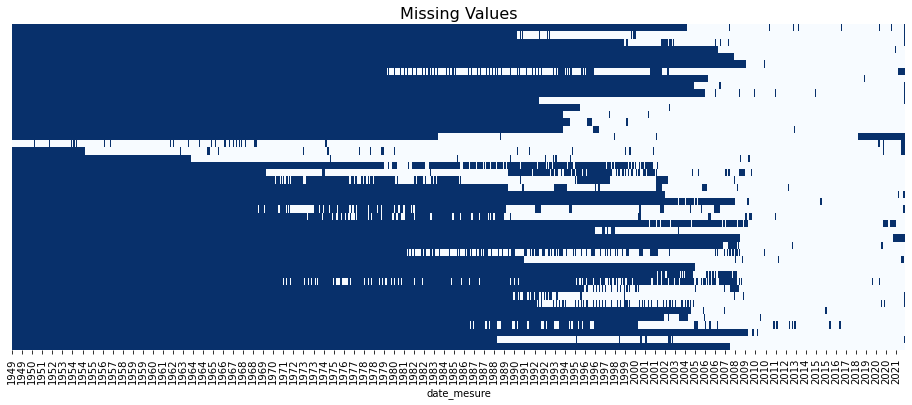

In [6]:
f_plot_nan(data)

# Traitement des données

## Rééchantillonnage à la semaine

In [7]:
data_week = pd.DataFrame(data.resample('7D').mean())

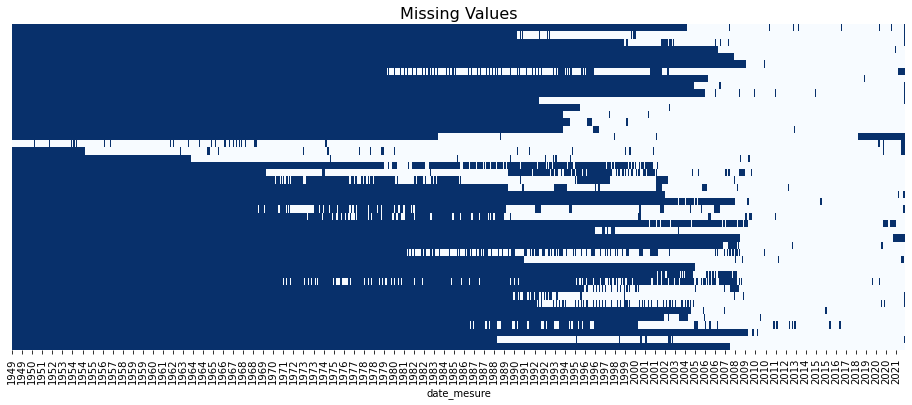

In [8]:
f_plot_nan(data_week)

In [9]:
data_week.shape

(3822, 45)

## Suppression des valeurs abbérantes
Utilisation de la méthode IQR pour supprimer les valeurs abbérantes.
- Calcul des quartiles et de l'écart interquartile
- Suppression des valeurs < Q1 - 1.5*IQR
- Suppression des valeurs > Q3 + 1.5*IQR

In [13]:
data_wo_outliers = data_week.copy()

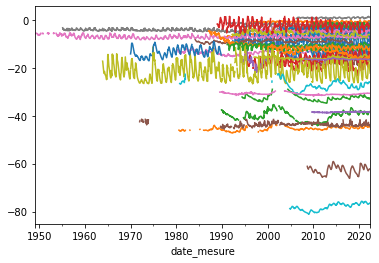

In [14]:
for piezo in data_wo_outliers.columns : 
    q1 = np.nanquantile(data_wo_outliers[piezo], .25)
    q3 = np.nanquantile(data_wo_outliers[piezo], .75)
    IQR = q3-q1
    data_wo_outliers.loc[data_wo_outliers[piezo] < (q1-1.5*IQR), piezo] = np.NaN
    data_wo_outliers.loc[data_wo_outliers[piezo] > (q3+1.5*IQR), piezo] = np.NaN
    data_wo_outliers[f"{piezo}"].plot()

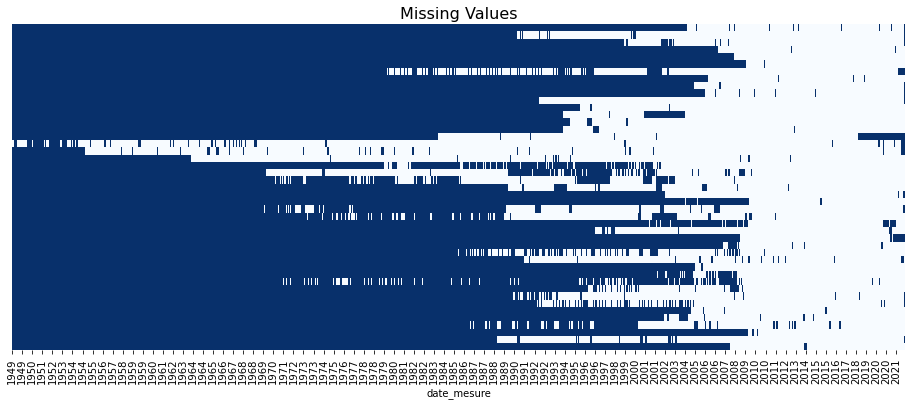

In [15]:
f_plot_nan(data_wo_outliers)

## Réajustement des dates de début et de fin

In [17]:
debut = []
for column in data_wo_outliers.columns:
    debut.append(data_wo_outliers[f"{column}"].first_valid_index())
date_debut = max(debut)
date_debut

Timestamp('2009-07-16 00:00:00', freq='7D')

In [18]:
fin = []
for column in data_wo_outliers.columns:
    fin.append(data_wo_outliers[f"{column}"].last_valid_index())
date_fin = min(fin)
date_fin

Timestamp('2018-07-19 00:00:00', freq='7D')

In [19]:
data_wo_outliers = data_wo_outliers.loc[date_debut:date_fin]

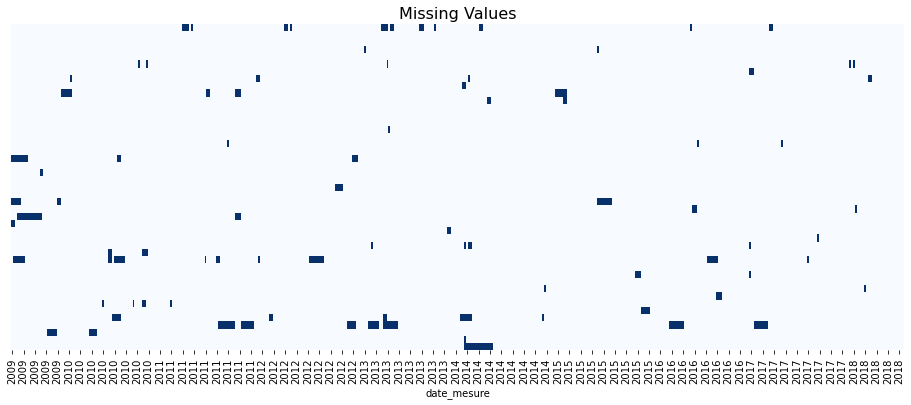

In [21]:
f_plot_nan(data_wo_outliers)

## Interpolation

In [30]:
data_interpol = data_wo_outliers.copy().interpolate('linear')

In [31]:
data_interpol.shape

(471, 45)

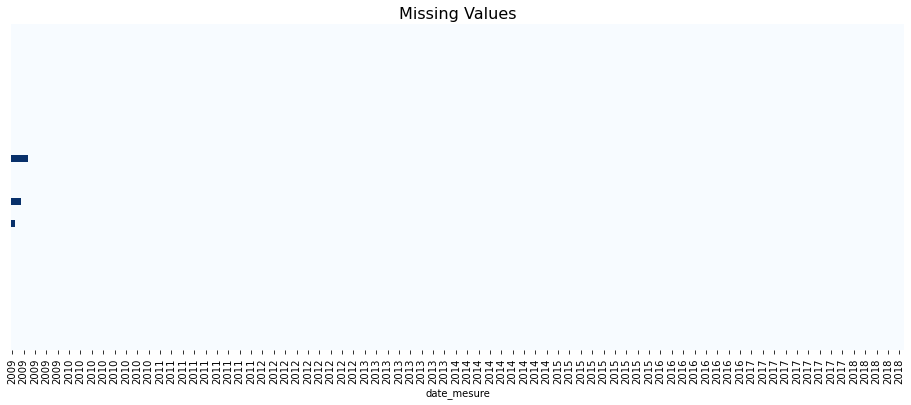

In [32]:
f_plot_nan(data_interpol)

## Nouvel ajustement des dates de début et de fin

In [33]:
debut = []
for column in data_interpol.columns:
    debut.append(data_interpol[f"{column}"].first_valid_index())
date_debut = max(debut)
date_debut

Timestamp('2009-09-17 00:00:00', freq='7D')

In [34]:
fin = []
for column in data_interpol.columns:
    fin.append(data_interpol[f"{column}"].last_valid_index())
date_fin = min(fin)
date_fin

Timestamp('2018-07-19 00:00:00', freq='7D')

In [35]:
data_interpol = data_interpol.loc[date_debut:date_fin]

In [36]:
print(f"Nombre total de Nan : {data_interpol.isna().sum().sum()}")

Nombre total de Nan : 0


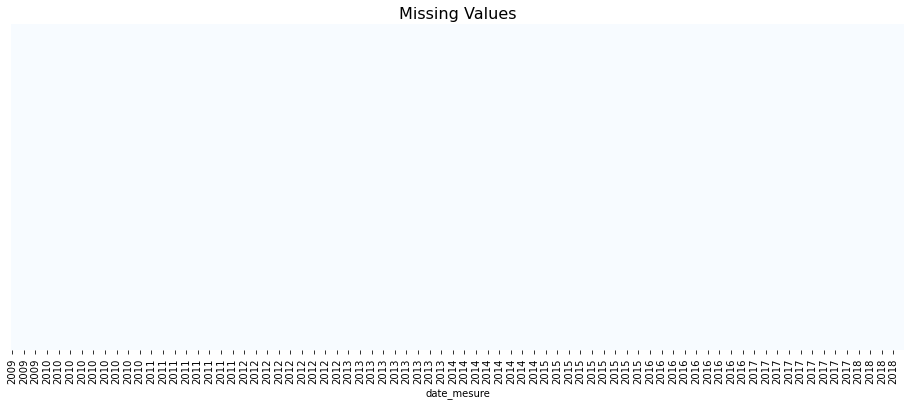

In [38]:
f_plot_nan(data_interpol)

## Affichage des chroniques après nettoyage

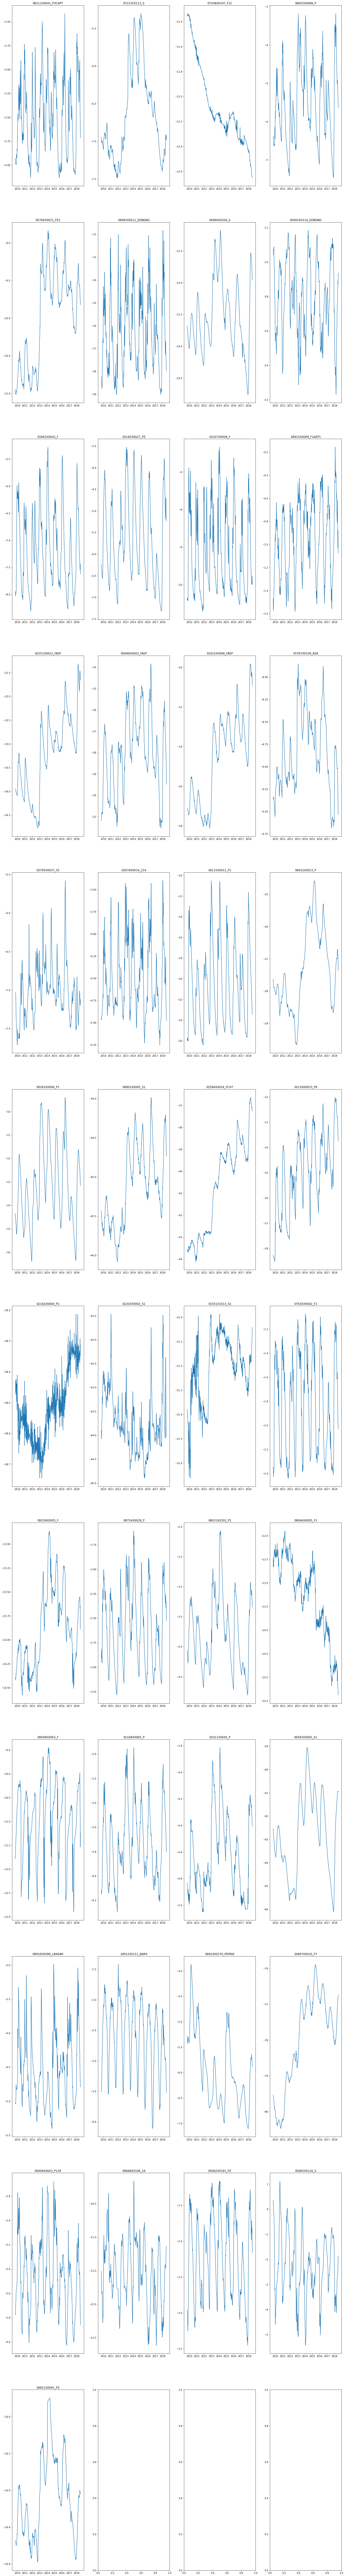

In [39]:
if data_interpol.shape[1]%4 == 0:
    nbre_lignes = data_interpol.shape[1]//4
else : 
    nbre_lignes = data_interpol.shape[1]//4 + 1

fig, axs = plt.subplots(nbre_lignes,4,figsize=(25,200))
#fig.suptitle('Series')
for i in range(nbre_lignes):
    for j in range(4):
        if i*4+j+1>data_interpol.shape[1]: # pass the others that we can't fill
            continue
        axs[i, j].plot(data_interpol.iloc[:,i*4+j])
        axs[i, j].set_title(data_interpol.columns[i*4+j])
plt.show()

## Normalisation StandardScaler

In [40]:
def scaleColumns(df):
    for col in df.columns:
        df[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df[col])),columns=[col], index=df.index)
    return df

In [41]:
scaler = StandardScaler()
data_norm = scaleColumns(data_interpol.copy())

In [42]:
data_norm.head()

,06211X0041_P3CAPT,07223C0113_S,07208X0197_F1C,06003X0088_P,05794X0021_PZ1,04992X0011_SONDAG,04994X0204_S,05002X0114_SONDAG,03462X0043_F,03182X0027_PZ,...,00583X0005_S1,09916X0098_LANSAR,10912X0111_BAR4,09914X0370_PERRIE,10897X0010_F3,09406X0643_P130,09668X0106_16,05082X0181_PZ,05865X0126_S,04851X0091_PZ
date_mesure,,,,,,,,,,,,,,,,,,,,,
2009-09-17,-1.084236,-0.502191,2.265778,-0.860052,-1.510983,-1.138977,-0.257286,1.159101,-1.093229,-0.583066,...,0.161013,-0.973527,-1.585929,0.947934,-1.187782,-1.062780,0.075259,-1.311263,2.062747,-1.077204
2009-09-24,-1.130973,-0.539431,2.297523,-0.916339,-1.573529,-1.189025,-0.305518,1.245376,-1.159135,-0.654331,...,0.101502,-1.015878,-1.482171,0.905164,-1.208427,-0.948008,-0.128612,-1.398966,1.929541,-1.109162
2009-10-01,-1.181305,-0.590635,2.302058,-0.969739,-1.607035,-1.335779,-0.358827,1.305105,-1.207067,-0.702326,...,0.054858,-1.010231,-1.363591,0.831289,-1.237765,-0.833237,-0.431419,-1.481658,1.834717,-1.109162
2009-10-08,-1.220851,-0.595290,2.297523,-1.015923,-1.602568,-1.353592,-0.419752,1.291832,-1.125183,-0.772136,...,-0.005457,-0.877532,-1.230187,0.786575,-1.268189,-0.728029,-0.629293,-1.556832,1.760212,-1.141120
2009-10-15,-1.246017,-0.632529,2.320199,-1.060663,-1.618204,-1.395158,-0.467984,1.285195,-1.143158,-0.808496,...,-0.060143,-0.832358,-1.007849,0.745750,-1.289921,-0.651515,-0.593316,-1.817436,1.698125,-1.160295


In [43]:
data_norm.columns

Index(['06211X0041_P3CAPT', '07223C0113_S', '07208X0197_F1C', '06003X0088_P',
       '05794X0021_PZ1', '04992X0011_SONDAG', '04994X0204_S',
       '05002X0114_SONDAG', '03462X0043_F', '03182X0027_PZ', '03107X0008_F',
       '04915X0009_F1AEP1', '02551X0022_FAEP', '05696X0002_FAEP',
       '01815X0006_FAEP', '03787X0109_60A', '03795X0037_55', '03078X0014_214',
       '00115X0011_P1', '00632X0023_P', '00263X0006_P1', '00801X0005_S1',
       '02584X0024_FCH7', '02218X0033_P6', '02182X0004_P2', '02203X0002_S1',
       '01551X1013_S1', '07545X0002_F1', '09258X0005_F', '08754X0028_P',
       '08031X0302_P1', '08046X0005_F2', '09508X0063_F', '01168X0065_P',
       '01011X0045_P', '00583X0005_S1', '09916X0098_LANSAR', '10912X0111_BAR4',
       '09914X0370_PERRIE', '10897X0010_F3', '09406X0643_P130',
       '09668X0106_16', '05082X0181_PZ', '05865X0126_S', '04851X0091_PZ'],
      dtype='object')

## Sauvegarde du dataframe en csv

In [44]:
data_norm.to_csv(f"../data/FRANCE.csv", sep = ";")